# Example
Comparison between swept wing by Bertin and pySailingVLM results. More information can be found at Aerodynamics for engineers John J.Bertin p 368 (Example 7.2).

In [1]:
# varaibles.py for jupyter
import os
import numpy as np
import time
from pySailingVLM.runner.container import Output, Rig, Conditions, Solver, MainSail, JibSail, Csys, Keel

half_wing_span = 0.5
sweep_angle_deg = 45.
chord_length = 0.2
AoA_deg = 4.
mgirths =  np.array([0.00, 1./8, 1./4, 1./2, 3./4, 7./8, 1.00])
mchords = np.array([chord_length]* len(mgirths))
jgirths = np.array([0.00, 1./4, 1./2, 3./4, 1.00])

out = Output(case_name='my_case_name',
             case_dir=os.path.abspath(''),
             name=os.path.join("results_example_jib_and_mainsail_vlm", time.strftime("%Y-%m-%d_%Hh%Mm%Ss")),
            file_name='my_fancy_results')

solver = Solver(n_spanwise=4,
                n_chordwise=1,
                interpolation_type='linear')

conditions = Conditions(leeway_deg=0.,    
                        heel_deg=0.,    
                        SOG_yacht=0.,  
                        tws_ref= 1.,     
                        alpha_true_wind_deg= AoA_deg, 
                        reference_water_level_for_wind_profile=-0.,
                        wind_exp_coeff=0.,
                        wind_reference_measurment_height=10.,
                        rho=1.,
                        wind_profile='flat',
                        roughness=0.05)

rig = Rig(main_sail_luff=half_wing_span / np.cos(np.deg2rad(sweep_angle_deg)),
          jib_luff=10.0,
          foretriangle_height=11.50,
          foretriangle_base=3.90,
          sheer_above_waterline=0.,
          boom_above_sheer=0.,
          rake_deg=90. + sweep_angle_deg,
          mast_LOA=0.,
          sails_def='main')

main = MainSail(centerline_twist_deg=0*mgirths,
                girths=mgirths,
                chords=mchords,
                camber= 0*np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))
              
jib = JibSail(centerline_twist_deg=0*(10+5)  + 0*15. * jgirths,
             girths=jgirths,
             chords=0* np.array([3.80, 2.98, 2.15, 1.33, 0.5]),
             camber=0*np.array([0.01, 0.01, 0.01, 0.01, 0.01]),
             camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5]))

csys = Csys(reference_level_for_moments=np.array([0, 0, 0]))
keel = Keel(center_of_lateral_resistance_upright=np.array([0, 0, -1.0]))    


<div class="alert alert-block alert-warning">
<b>Run cell below twice:</b> Run cell below twice before running other cells. Output below is expected to always appear at first time importing pySailingVLM:
<br><br>
    
<em>   
/home/user/miniconda3/envs/mgr_test/lib/python3.10/site-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7f01d6a1e9e0 at 0x7f01d6cfa680>. Debug line information may be inaccurate.warnings.warn(NumbaDebugInfoWarning(msg))
</em> 
<br>
</div>

In [2]:
import shutil
from pySailingVLM.rotations.csys_transformations import CSYS_transformations
from pySailingVLM.yacht_geometry.hull_geometry import HullGeometry
from pySailingVLM.results.save_utils import save_results_to_file
from pySailingVLM.solver.panels_plotter import display_panels_xyz_and_winds
from pySailingVLM.results.inviscid_flow import InviscidFlowResults
from pySailingVLM.solver.vlm import Vlm
from pySailingVLM.runner.sail import Wind, Sail
from pySailingVLM.solver.panels_plotter import plot_cp
from pySailingVLM.solver.coefs import get_C

In [3]:
# results from Aerodynamics for engineers John J.Bertin p 368
AoA_degs = np.linspace(0.001, 10., 20) # [4.0]
C_bertin = 1.096 * np.pi * np.pi / 180.* AoA_degs

In [4]:
import numpy as np
from pySailingVLM.solver.coefs import get_vlm_Cxyz

CL_results = []
cl_results = []

for AoA_deg in AoA_degs:
    conditions.alpha_true_wind_deg=  AoA_deg
    csys_transformations = CSYS_transformations(conditions.heel_deg, conditions.leeway_deg, v_from_original_xyz_2_reference_csys_xyz=csys.reference_level_for_moments)

    w = Wind(conditions)
    s = Sail(solver, rig, main, jib, csys_transformations)
    sail_set = s.sail_set
    myvlm = Vlm(sail_set.panels, solver.n_chordwise, solver.n_spanwise, conditions.rho, w.profile, sail_set.trailing_edge_info, sail_set.leading_edge_info)
    
    height = 1.0
    sails_Cxyz = myvlm.get_Cxyz(w, height)
    
    # enumerate through sails
    # in this example we have only main
    cl = get_C(myvlm.panels, myvlm.areas, myvlm.lift, myvlm.inlet_conditions.V_app_infs, myvlm.n_spanwise, myvlm.n_chordwise, myvlm.rho)
    cd = get_C(myvlm.panels, myvlm.areas, myvlm.drag, myvlm.inlet_conditions.V_app_infs, myvlm.n_spanwise, myvlm.n_chordwise, myvlm.rho)
    
    k = int(myvlm.panels.shape[0] / (solver.n_spanwise * solver.n_chordwise * 2) ) # *2 in denominator due to underwater part


    sail_areas = np.split(myvlm.areas, (2*k))
    section_areas = np.zeros((k, solver.n_spanwise), dtype=float) # reshaped in proper way array with areas
    sail_cps = np.split(myvlm.cp, (2*k))
    sail_section_mean_cp_z = np.zeros((k, solver.n_spanwise), dtype=float)
    # cl for every panel in all sails

    # iterating only above water
    for i in range(k):
        for j in range(solver.n_spanwise):   
            section_sail_areas = sail_areas[i].reshape(solver.n_chordwise, solver.n_spanwise)[:,j]
            section_areas[i, j] = np.sum(section_sail_areas)

            arr = sail_cps[i][:, 2].reshape(solver.n_chordwise, solver.n_spanwise).transpose()
            mean_section_cp_z = np.sum(arr, axis=1) / solver.n_chordwise
            sail_section_mean_cp_z[i] = mean_section_cp_z

    CL = np.sum(section_areas[0] * cl[0]) / np.sum(section_areas[0])
    CL_results.append(CL)

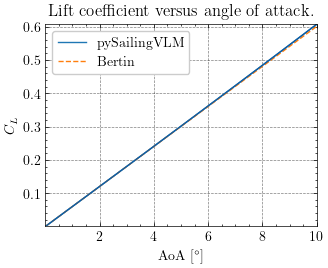

In [5]:
import matplotlib.pyplot as plt
import scienceplots # sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.style.use(['science', 'grid'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(AoA_degs, CL_results, color='tab:blue', label='pySailingVLM')
ax.plot(AoA_degs, C_bertin, color='tab:orange', linestyle='dashed', label='Bertin')

ax.set_xlabel(r"AoA [$^\circ$]")
ax.set_ylabel(r"$C_{L}$")

ax.set_title("Lift coefficient versus angle of attack.")
ax.legend()
plt.plot(AoA_degs, CL_results)   
ax.autoscale(tight=True)
plt.savefig('bertin_1', dpi=300)